# Project 2: Coronary Heart Disease (CHD) Risk Prediction  

**Objective:**  
Build a logistic regression model from scratch to predict the 10-year risk of coronary heart disease (CHD) as a binary classification problem.  

**Dataset Overview (Framingham Heart Study):**  
- **Demographic Information:**  
  - `sex`: Male or female  
  - `age`: Age of the patient  
  - `education`: Education level  

- **Behavioral Factors:**  
  - `currentSmoker`: Whether the patient is a current smoker  
  - `cigsPerDay`: Average cigarettes smoked per day  

- **Medical History:**  
  - `BPMeds`: On blood pressure medication (yes/no)  
  - `prevalentStroke`: History of stroke (yes/no)  
  - `prevalentHyp`: Hypertension (yes/no)  
  - `diabetes`: Diabetes (yes/no)  

- **Current Medical Condition:**  
  - `totChol`: Total cholesterol level  
  - `sysBP`: Systolic blood pressure  
  - `diaBP`: Diastolic blood pressure  
  - `BMI`: Body Mass Index  
  - `heartRate`: Heart rate  
  - `glucose`: Glucose level  

- **Target Variable:**  
  - `TenYearCHD`: Binary outcome (1 = patient has CHD risk, 0 = no risk)  

**Approach:**  
- Implemented logistic regression using gradient descent and L2 regularization.  
- Handled missing data (median/mode imputation).  
- Standardized features for stable training.  
- Evaluated performance using:  
  - Accuracy  
  - Precision  
  - Recall (sensitivity)  
  - F1-score  
  - ROC Curve and AUC  


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Load dataset
df = pd.read_csv(r"C:\Users\TUF\Downloads\framingham.csv")
df.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [13]:
# Preprocessing: fill missing values, convert dtypes
num_cols = ['cigsPerDay','BPMeds','totChol','BMI','heartRate','glucose']
for c in num_cols:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

if 'education' in df.columns:
    df['education'] = df['education'].fillna(df['education'].mode()[0])

for c in ['male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']:
    if c in df.columns:
        df[c] = df[c].astype(int)

features = ['male','age','education','currentSmoker','cigsPerDay','BPMeds',
            'prevalentStroke','prevalentHyp','diabetes','totChol','sysBP',
            'diaBP','BMI','heartRate','glucose']
X = df[features].astype(float).values
y = df['TenYearCHD'].values.reshape(-1,1)


In [14]:
# Train-test split and standardize
np.random.seed(42)
idx = np.random.permutation(len(X))
train_n = int(0.8*len(X))
train_idx = idx[:train_n]
test_idx = idx[train_n:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

means = X_train.mean(axis=0)
stds = X_train.std(axis=0)
stds[stds==0] = 1.0

X_train_std = (X_train - means)/stds
X_test_std = (X_test - means)/stds

def add_intercept(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

X_train_i = add_intercept(X_train_std)
X_test_i = add_intercept(X_test_std)


In [15]:
# Logistic regression implementation from scratch

def sigmoid(z):
    return 1/(1+np.exp(-z))

def compute_loss_and_grad(w, X, y, reg_lambda=0.0):
    m = X.shape[0]
    z = X.dot(w)
    preds = sigmoid(z)
    eps = 1e-12
    loss = -(1/m) * (y.T.dot(np.log(preds+eps)) + (1-y).T.dot(np.log(1-preds+eps)))[0,0]
    loss += (reg_lambda/(2*m)) * np.sum(w[1:]**2)
    grad = (1/m) * X.T.dot(preds - y)
    grad[1:] += (reg_lambda/m) * w[1:]
    return loss, grad

def train_logistic_regression(X, y, lr=0.5, reg_lambda=1.0, num_iters=20000, tol=1e-7, verbose=True):
    n_features = X.shape[1]
    w = np.zeros((n_features,1))
    prev_loss = None
    for i in range(num_iters):
        loss, grad = compute_loss_and_grad(w, X, y, reg_lambda)
        w -= lr*grad
        if verbose and i % 5000 == 0:
            print(f"Iter {i}, loss={loss:.6f}")
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            print(f"Converged at iter {i}, loss={loss:.6f}")
            break
        prev_loss = loss
    return w


In [16]:
# Train model
w = train_logistic_regression(X_train_i, y_train, lr=0.5, reg_lambda=1.0, num_iters=20000, tol=1e-7, verbose=True)
w.shape


Iter 0, loss=0.693147
Converged at iter 178, loss=0.386820


(16, 1)

In [17]:
def predict_proba(X, w):
    return sigmoid(X.dot(w))

def predict(X, w, threshold=0.5):
    return (predict_proba(X,w) >= threshold).astype(int)

y_pred_proba = predict_proba(X_test_i, w)
y_pred = predict(X_test_i, w)

def confusion_matrix(y_true, y_pred):
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return tp, tn, fp, fn

tp, tn, fp, fn = confusion_matrix(y_test, y_pred)
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp) if (tp+fp)>0 else 0
recall = tp/(tp+fn) if (tp+fn)>0 else 0
f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Confusion matrix:", tp, tn, fp, fn)


Accuracy: 0.8679245283018868
Precision: 0.9
Recall: 0.075
F1: 0.13846153846153847
Confusion matrix: 9 727 1 111


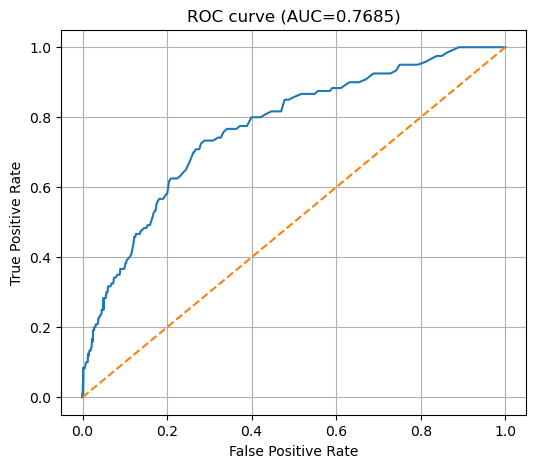

In [18]:
def roc_auc(y_true, scores, n_points=500):
    thresholds = np.linspace(0,1,n_points)
    tprs = []
    fprs = []
    P = (y_true==1).sum()
    N = (y_true==0).sum()
    for t in thresholds:
        preds = (scores >= t).astype(int)
        tp = ((y_true==1) & (preds==1)).sum()
        fp = ((y_true==0) & (preds==1)).sum()
        tpr = tp/P if P>0 else 0
        fpr = fp/N if N>0 else 0
        tprs.append(tpr)
        fprs.append(fpr)
    fprs = np.array(fprs)
    tprs = np.array(tprs)
    order = np.argsort(fprs)
    fprs_s = fprs[order]
    tprs_s = tprs[order]
    auc = np.trapz(tprs_s, fprs_s)
    return auc, fprs_s, tprs_s

auc, fprs, tprs = roc_auc(y_test.flatten(), y_pred_proba.flatten())

plt.figure(figsize=(6,5))
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC={auc:.4f})')
plt.grid(True)
plt.show()


In [20]:
# Save predictions
import pickle
pred_df = pd.DataFrame({
    "y_true": y_test.flatten(),
    "y_pred": y_pred.flatten(),
    "y_pred_proba": y_pred_proba.flatten()
})
pred_df.to_csv(os.path.join("predictions.csv"), index=False)

# Save trained model parameters
model = {
    "weights": w,
    "means": means,
    "stds": stds,
    "features": features
}
with open(os.path.join("23IE10006_CHD_logistic_model.pkl"), "wb") as f:
    pickle.dump(model, f)


**Conclusion:**  
The logistic regression model achieved an overall accuracy of ~86.8%, which appears high at first glance. However, due to the class imbalance in the dataset, the model is biased toward predicting the majority class (no CHD risk).  

- **Precision (90%)** is high, meaning that when the model predicts CHD risk, it is usually correct.  
- **Recall (7.5%)** is very low, indicating that the model fails to identify most patients who actually have CHD risk (111 false negatives vs only 9 true positives).  
- **F1-score (0.14)** is poor, showing an imbalance between precision and recall.  
- The **confusion matrix** highlights this issue: the model predicts "no risk" for almost everyone, missing the majority of true positive cases.  
